In [151]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [398]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from fnn.evaluation import *
import fnn.models as models
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.distributions import *
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt
from torchdeepretina.pyret_func import estfr

In [155]:
file_path = '/home/xhding/tem_stim/21-03-15/naturalscene.h5'
cells = [0,1,2,3,4,6]
t_list = [3,3,3,3,2,3]
recording = recording_stats(file_path, cells)
recording_cut = recording_stats(file_path, cells, truncate=True, t_list=t_list)
single_trial_bin = recording.single_trial_bin
single_trial_bin_cut = recording_cut.single_trial_bin

optimum_para = {}
optimum_para['gaussian'] = [0.61, 0.56, 0.56, 0.58, 1., 1.22]
optimum_para['poisson1'] = [5.56, 8.87, 4.65, 3.80, 1., 0.83]
optimum_para['poisson2'] = [3.81, 5.03, 3.30, 2.92, 6.10, 0.61]
optimum_para['binomial'] = [2.17, 2.85, 1.91, 1.69, 1., 0.47]

In [410]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model_func = getattr(models, 'BN_CNN_Stack_Old')
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)

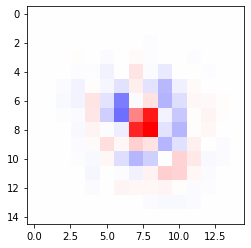

In [25]:
import pyret
from kinetic.utils import LinearStack
state_dict = checkpoint['model_state_dict']
conv_weights = []
for i in range((cfg.Model.ksizes[0]-1)//2):
    conv_weights.append(state_dict['bipolar.0.convs.{}.weight'.format(i)].cpu().numpy())
#kernel = LinearStack(conv_weights)[0, 10]
kernel = pyret.filtertools.decompose(LinearStack(conv_weights)[5])[0]
plt.imshow(kernel, cmap='bwr', vmin=-np.abs(kernel).max(), vmax=np.abs(kernel).max())

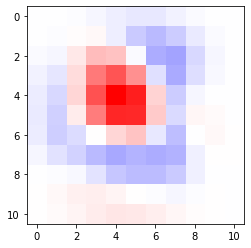

In [38]:
state_dict = checkpoint['model_state_dict']
conv_weights = []
for i in range((cfg.Model.ksizes[1]-1)//2):
    conv_weights.append(state_dict['amacrine.1.convs.{}.weight'.format(i)].cpu().numpy())
kernel = pyret.filtertools.decompose(LinearStack(conv_weights)[7])[0]
plt.imshow(kernel, cmap='bwr', vmin=-np.abs(kernel).max(), vmax=np.abs(kernel).max())

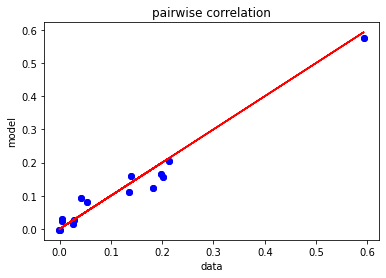

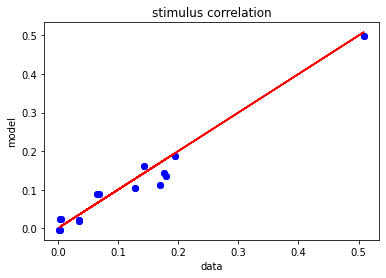

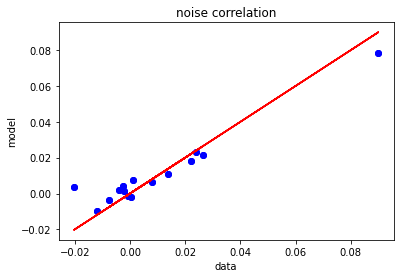

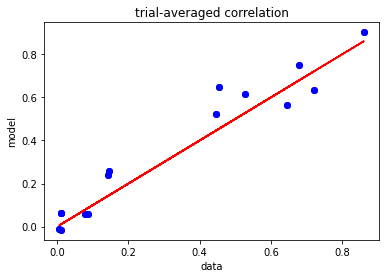

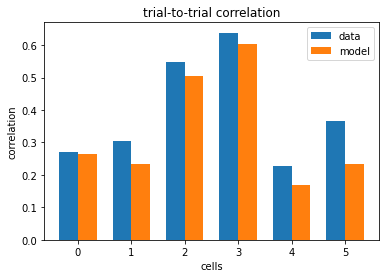

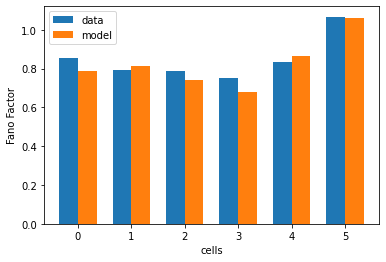

In [39]:
binomial_para = [2.17, 2.85, 2.3, 2.3, 1.0, 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.55, 0], 27)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=27, thre=10)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)

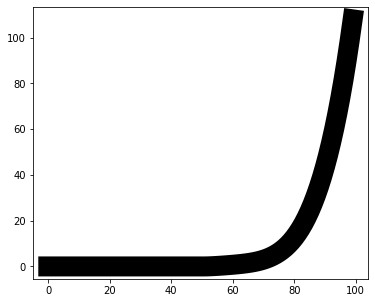

In [62]:
plt.figure(figsize=(6,5))
x = np.linspace(-2, 2, 100)
x[x<0] = 0
a,b,c,d,_ = poly_paras[3]
y = a*x**4+b*x**3+c*x**2+d*x
plt.plot(y, color='black', linewidth=20)

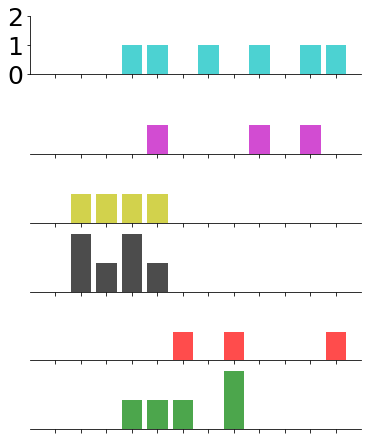

In [128]:
colors = ['c', 'm', 'y', 'k', 'r', 'g']
fig, axes = plt.subplots(6,1, figsize=(5, 6), sharex=True, constrained_layout=True)
for cell in range(6):
    axes[cell].bar(np.arange(1168,1180), single_trial_bin[0,1168:1180,cell], color=colors[cell], alpha=0.7)
    axes[cell].set_ylim([0,2])
    axes[cell].xaxis.set_ticks(np.arange(1168,1180))
    axes[cell].spines['right'].set_visible(False)
    axes[cell].spines['top'].set_visible(False)
    axes[cell].tick_params(axis='x', labelbottom=False)
    if cell == 0:
        axes[cell].yaxis.set_ticks([0,1,2])
        axes[cell].tick_params(axis='y', labelsize=25)
        continue
    axes[cell].spines['left'].set_visible(False)
    axes[cell].tick_params(axis='y', left=False, labelleft=False)
plt.show()

In [150]:
dist = distribution(5)
for cell in range(6):
    optim_k = dist.optimize_k('second_norm', single_trial_bin, cell, 0.2, 1.5)
    print(cell, dist.KL('second_norm', optim_k, recording, cell))

0 0.0637153845222761
1 0.08067855469590485
2 0.06673183823007811
3 0.09488594040968178
4 0.09688712306228817
5 0.3362610462323396


In [156]:
stats = variance_mean(recording, t_list, optimum_para)

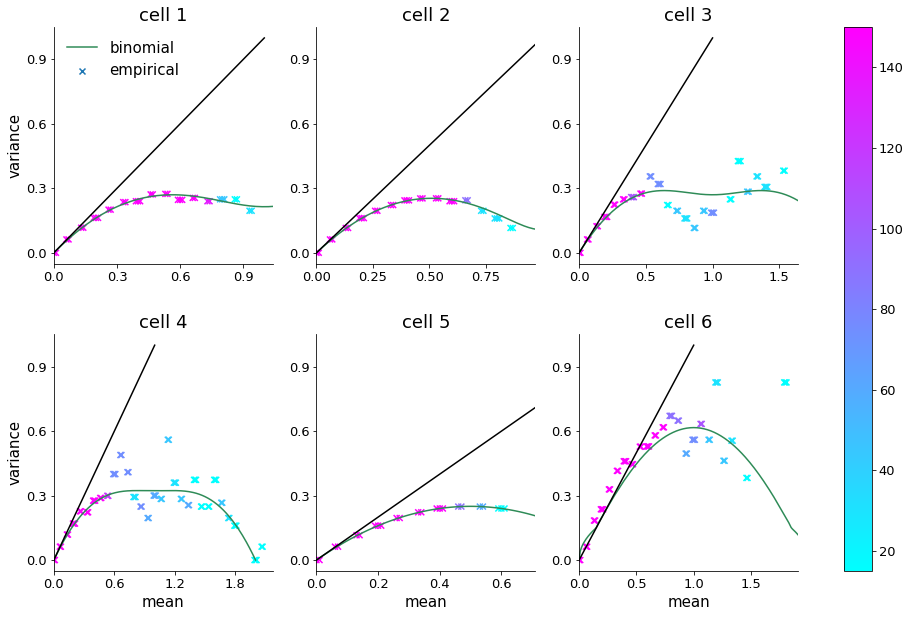

In [296]:
variance_mean_plot(stats, save='var_mean')

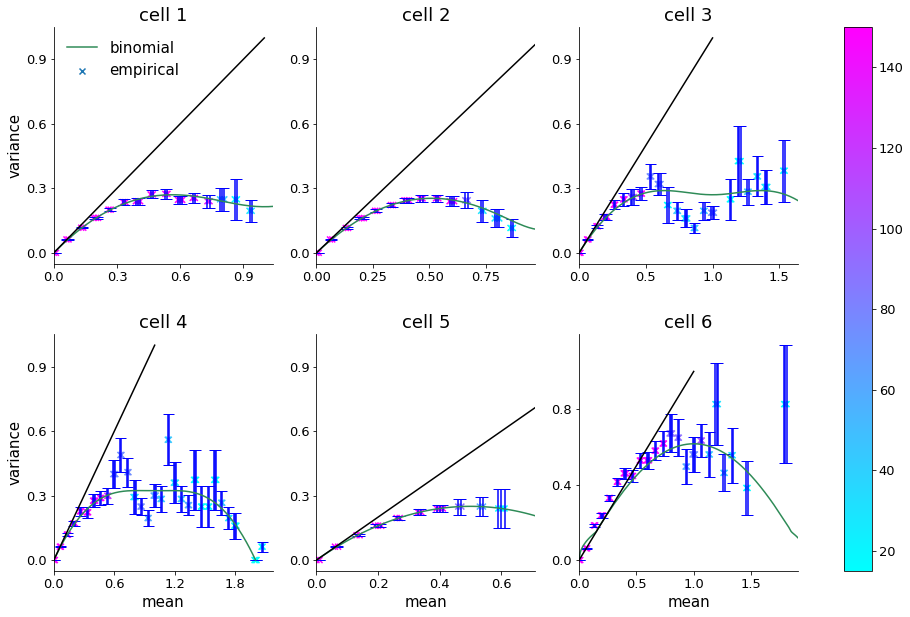

In [316]:
variance_mean_plot2(stats, save='var_mean')

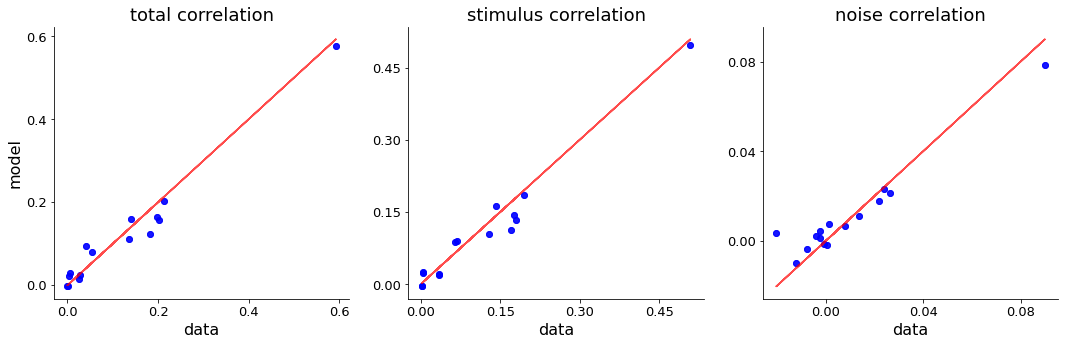

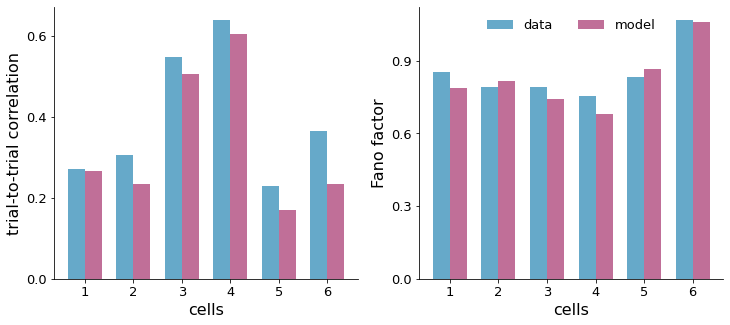

In [302]:
second_stats_plot(single_trial_bin, pred_single_trial_try, save=['corr','var'])

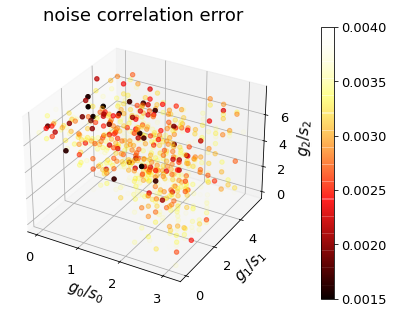

In [229]:
cmap = pl.cm.hot
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(1, 0, cmap.N)
my_cmap = ListedColormap(my_cmap)

g0s = []
g1s = []
g2s = []
errors =[]
f = open('./errors3.txt', 'r')
for line in f.readlines():
    g0 = round(float(line.split()[0][1:-1]), 3)
    g1 = round(float(line.split()[1][:-1]), 3)
    g2 = round(float(line.split()[2][:-1]), 3)
    error = float(line.split()[3])
    g0s.append(g0)
    g1s.append(g1)
    g2s.append(g2)
    errors.append(error)
g0s = np.array(g0s)/0.759
g1s = np.array(g1s)/0.0759
g2s = np.array(g2s)/0.0870
errors = np.array(errors)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(g0s, g1s, g2s, c=errors, marker='o', cmap=my_cmap, vmax=0.004, vmin=0.0015, depthshade=False)
ax.set_xlabel(r'$g_0/s_0$', fontsize=15)
ax.set_ylabel(r'$g_1/s_1$', fontsize=15)
ax.set_zlabel(r'$g_2/s_2$', fontsize=15)
ax.set_title('noise correlation error', fontsize=18)
cbar = fig.colorbar(p, ax=ax)
plt.locator_params(nbins=5)
ax.tick_params(axis='both', which='major', labelsize=13)
cbar.ax.tick_params(labelsize=13)
plt.savefig('/home/xhding/workspaces/torch-deep-retina/fnn/notebook/figs/3d.png', dpi=300, bbox_inches = "tight")
plt.show()

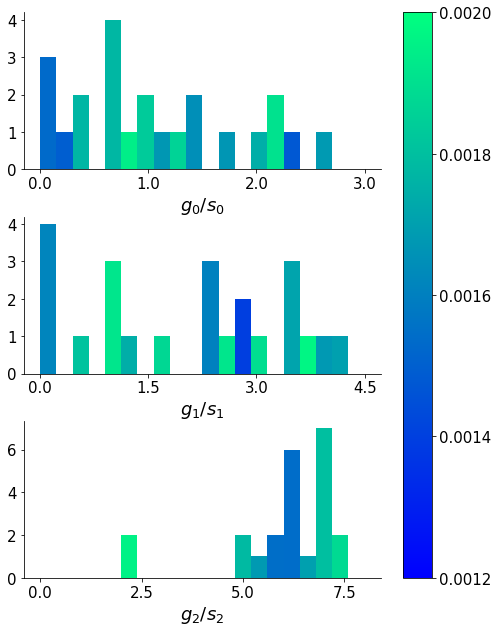

In [295]:
from matplotlib import cm, colors
from matplotlib.ticker import FormatStrFormatter

thre = 0.002
nbins = 21
indices = errors < thre
cmap = cm.winter

fig, ax = plt.subplots(3, 1, figsize=(8, 10.4))

bins = np.linspace(0,3.,nbins)
color = color_seq(bins, g0s, errors, cmap, thre, vmax=thre, vmin=0.0012)
_, _, patches = ax[0].hist(g0s[indices], bins=bins)
for i in range(bins.shape[0]-1):
    patches[i].set_facecolor(color[i])
ax[0].set_xlabel(r'$g_0/s_0$', fontsize=18)
    
bins = np.linspace(0,4.5,nbins)
color = color_seq(bins, g1s, errors, cmap, thre, vmax=thre, vmin=0.0012)
_, _, patches = ax[1].hist(g1s[indices], bins=bins)
for i in range(bins.shape[0]-1):
    patches[i].set_facecolor(color[i])
ax[1].set_xlabel(r'$g_1/s_1$', fontsize=18)

bins = np.linspace(0,8,nbins)
color = color_seq(bins, g2s, errors, cmap, thre, vmax=thre, vmin=0.0012)
_, _, patches = ax[2].hist(g2s[indices], bins=bins)
for i in range(bins.shape[0]-1):
    patches[i].set_facecolor(color[i])
ax[2].set_xlabel(r'$g_2/s_2$', fontsize=18)
    
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    #ax[i].yaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
fig.subplots_adjust(hspace=0.3)
    
norm = colors.Normalize(vmin=0.0012, vmax=thre)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.locator_params(nbins=5)

plt.savefig('/home/xhding/workspaces/torch-deep-retina/fnn/notebook/figs/hist.png', dpi=300, bbox_inches = "tight")

plt.show()

In [257]:
def color_seq(bins, gs, errors, cmap, thre, vmax=0.004, vmin=0.0015):
    
    colors = []
    for i in range(bins.shape[0]-1):
        indices = (errors<thre) * (gs>=bins[i]) * (gs<bins[i+1])
        mean_error = errors[indices].mean()
        if np.isnan(mean_error):
            colors.append((1.0, 1.0, 1.0, 0.0))
        else:
            n = round((mean_error - vmin)/(vmax - vmin)*cmap.N)
            colors.append(cmap(n))
    return colors

In [304]:
noise = single_trial_bin - single_trial_bin.mean(0)
cov_noise = (np.expand_dims(noise, -1) * np.expand_dims(noise, -2)).mean((0,1))

In [307]:
w,v = np.linalg.eig(cov_noise)

In [308]:
w

array([0.02556951, 0.02685992, 0.02036877, 0.00489776, 0.01101711,
       0.00878595])

In [309]:
for i in range(6):
    print(v[:,i])

[ 0.98758758  0.12737659  0.00237539  0.00222752  0.0377711  -0.08371803]
[-0.06280756 -0.15619296  0.0240115   0.02180413 -0.01716365 -0.98504437]
[-0.13942202  0.97909219 -0.00544601 -0.00146838  0.01854417 -0.14684782]
[-0.00116239  0.00593181  0.90652474 -0.42192063  0.00444629  0.01181429]
[-0.03577954 -0.02587929 -0.01352393 -0.01912759  0.99868053 -0.01176942]
[-0.00243879  0.0072474   0.42121034  0.90616476  0.02350087  0.0289224 ]


In [321]:
binomial_para = [2.17, 2.85, 2.3, 2.3, 1.0, 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.55, 0], 27)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=27, thre=10)

fanos = []
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    fano = np.nanmean(np.var(pred_single_trial, axis=0)/np.mean(pred_single_trial, axis=0), axis=0).mean()
    fanos.append(fano)
print(np.array(fanos).mean())

0.8207022237444103


In [325]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.55, 0], 27)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=27, thre=15)

fanos = []
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    fano = np.nanmean(np.var(pred_single_trial, axis=0)/np.mean(pred_single_trial, axis=0), axis=0).mean()
    fanos.append(fano)
print(np.array(fanos).mean())

0.8066195637827218


In [326]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [2.32, 0.387, 0.638, 0], 27)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=27, thre=15)

fanos = []
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    fano = np.nanmean(np.var(pred_single_trial, axis=0)/np.mean(pred_single_trial, axis=0), axis=0).mean()
    fanos.append(fano)
print(np.array(fanos).mean())

0.9866953894478435


In [327]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0., 0., 0], 27)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=27, thre=15)

fanos = []
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    fano = np.nanmean(np.var(pred_single_trial, axis=0)/np.mean(pred_single_trial, axis=0), axis=0).mean()
    fanos.append(fano)
print(np.array(fanos).mean())

0.7150360720062815


In [334]:
g0s[indices].max()*0.759, g1s[indices].max()*0.0759, g2s[indices].max()*0.087

(2.0, 0.32, 0.66)

In [335]:
g0s[indices].min()*0.759, g1s[indices].min()*0.0759, g2s[indices].min()*0.087

(0.0, 0.0, 0.17600000000000002)

In [336]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [2., 0.32, 0.66, 0], 27)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=27, thre=15)

fanos = []
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    fano = np.nanmean(np.var(pred_single_trial, axis=0)/np.mean(pred_single_trial, axis=0), axis=0).mean()
    fanos.append(fano)
print(np.array(fanos).mean())

0.9277550258093815


In [337]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0., 0.176, 0], 27)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=27, thre=15)

fanos = []
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    fano = np.nanmean(np.var(pred_single_trial, axis=0)/np.mean(pred_single_trial, axis=0), axis=0).mean()
    fanos.append(fano)
print(np.array(fanos).mean())

0.7225588203616696


In [339]:
thre = 0.002
indices = errors < thre
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]

fanos = []
for j in range(indices.sum()):
    gaussian = [g0s[indices][j]*0.759, g1s[indices][j]*0.0759, g2s[indices][j]*0.087, 0]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, gaussian, 27)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=27, thre=15)

    min_error = 10
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
            pred_single_trial_try = pred_single_trial
    fano = np.nanmean(np.var(pred_single_trial_try, axis=0)/np.mean(pred_single_trial_try, axis=0), axis=0).mean()
    fanos.append(fano)
    print(gaussian, fano)

[0.0, 0.04, 0.594, 0] 0.8278939060367225
[0.24000000000000002, 0.08, 0.594, 0] 0.8220281698357428
[0.48000000000000004, 0.0, 0.528, 0] 0.8080328235912727
[0.48000000000000004, 0.08, 0.66, 0] 0.8446724317227434
[0.48000000000000004, 0.12, 0.594, 0] 0.819432602902988
[0.72, 0.28, 0.198, 0] 0.7917684892650247
[0.72, 0.32, 0.528, 0] 0.8721540894647769
[0.9600000000000001, 0.08, 0.66, 0] 0.8469983795752235
[1.6800000000000002, 0.2, 0.594, 0] 0.8639519819226832
[0.08, 0.213, 0.55, 0] 0.8341734035537045
[0.08, 0.213, 0.616, 0] 0.8397163538802485
[0.32, 0.173, 0.55, 0] 0.8179484727001084
[0.56, 0.293, 0.55, 0] 0.8664699877911638
[0.8, 0.173, 0.616, 0] 0.8472057435579757
[1.28, 0.013, 0.41800000000000004, 0] 0.785390671816939
[1.52, 0.093, 0.616, 0] 0.8279257938078893
[1.76, 0.013, 0.55, 0] 0.8251834405457368
[2.0, 0.013, 0.48399999999999993, 0] 0.8206200478863098
[0.16, 0.267, 0.506, 0] 0.8492479979807136
[0.64, 0.267, 0.17600000000000002, 0] 0.8060704256382314
[1.12, 0.187, 0.506, 0] 0.828029

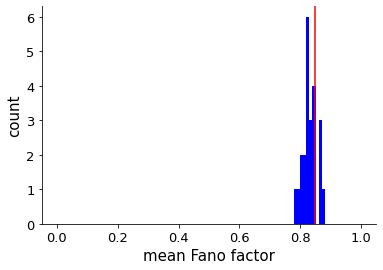

In [364]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(fanos, range=(0, 1), bins=100, color='blue')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('mean Fano factor', fontsize='15')
ax.set_ylabel('count', fontsize='15')
ax.tick_params(axis='both', which='major', labelsize=13)
ax.axvline(x=0.8482, color='red')
plt.show()

In [360]:
np.nanmean(np.var(single_trial_bin, axis=0)/np.mean(single_trial_bin, axis=0), axis=0).mean()

0.848176607184722

In [366]:
single_trial_bin.shape

(15, 5963, 6)

In [367]:
g = h5py.File('/home/xhding/tem_stim/21-03-15/naturalscene.h5', 'r')

In [370]:
g['test/response/binned']

<HDF5 dataset "binned": shape (7, 6003), type "<f8">

In [376]:
pred.shape

(5963, 6)

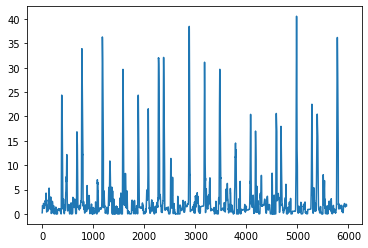

In [377]:
plt.plot(pred[:,0])

In [382]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [3,3,3,3,2,3]

for g2 in np.linspace(0., 1., 101):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, g2, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=15)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g2_errors.append((g2, min_error_stim, min_error))

for g1 in np.linspace(0., 0.8, 81):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, g1, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=15)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g1_errors.append((g1, min_error_stim, min_error))

for g0 in np.linspace(0, 5, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [g0, 0, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=15)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g0_errors.append((g0, min_error_stim, min_error))

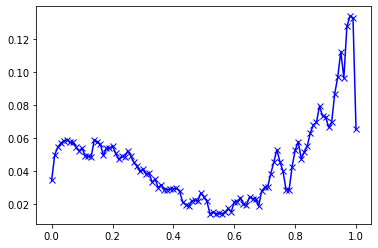

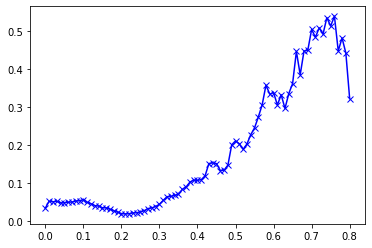

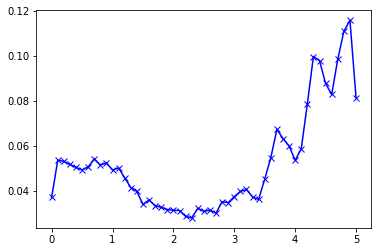

In [383]:
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

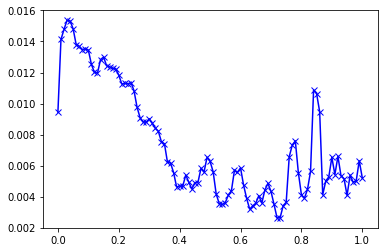

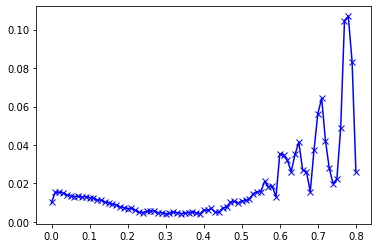

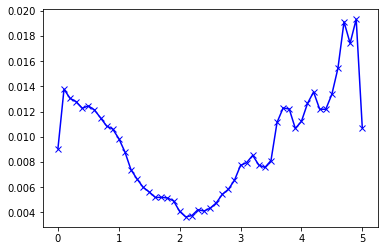

In [384]:
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

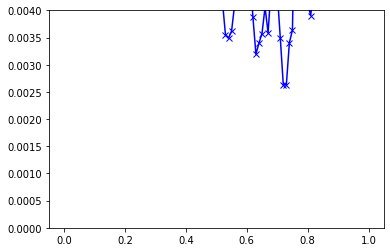

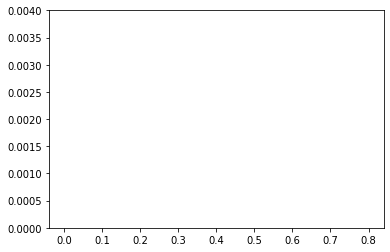

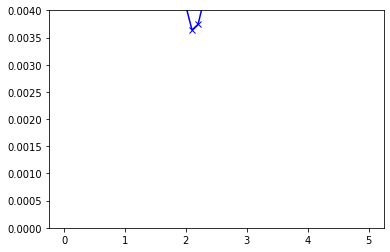

In [386]:
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.ylim([0, 0.004])
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.ylim([0, 0.004])
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.ylim([0, 0.004])
plt.show()

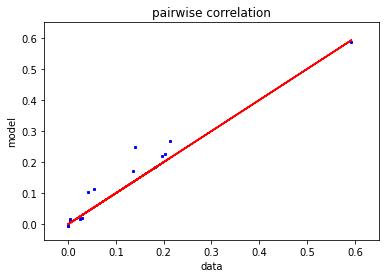

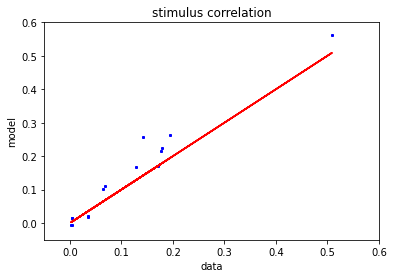

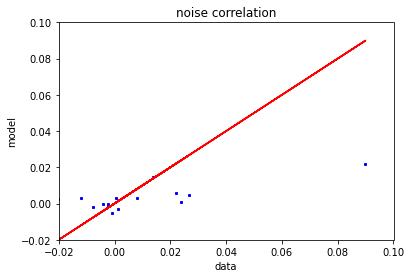

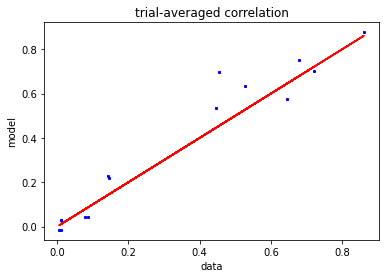

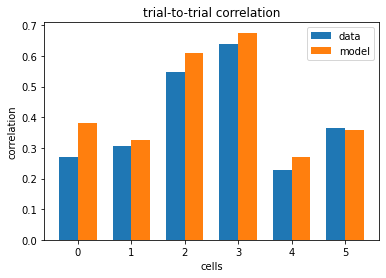

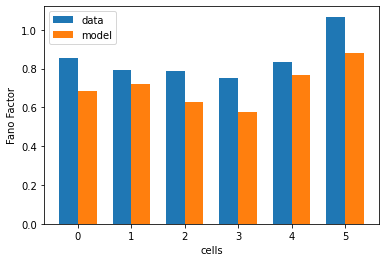

In [390]:
binomial_para =  [2.17, 2.85, 1.91, 1.69, 1., 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0., 0], 27)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=27, thre=15)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)

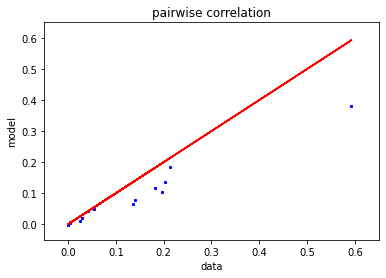

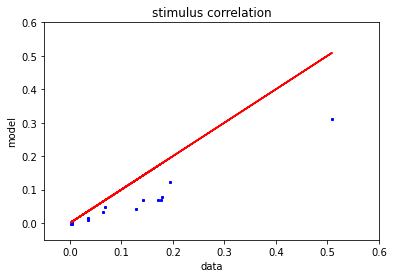

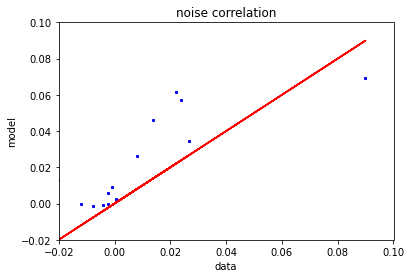

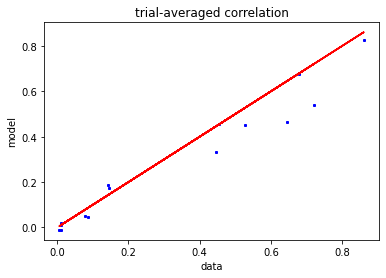

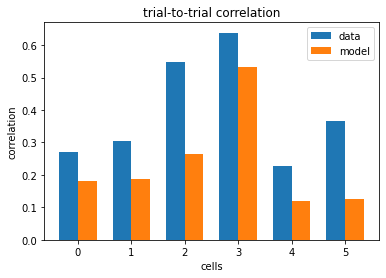

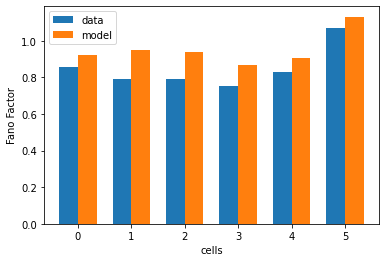

In [412]:
thre = 25
saved_bias = model.ganglion[1].bias.data
model.ganglion[1].bias.data = saved_bias - thre
binomial_para =  [2.17, 2.85, 1.91, 1.69, 1., 0.47]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.55, 0], 27)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=27, thre=0)
model.ganglion[1].bias.data = saved_bias

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)

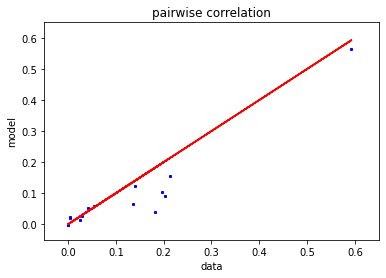

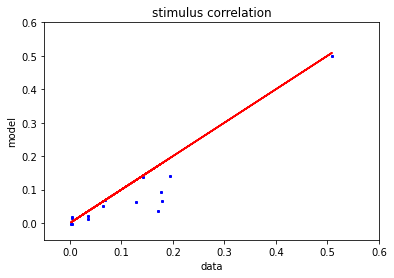

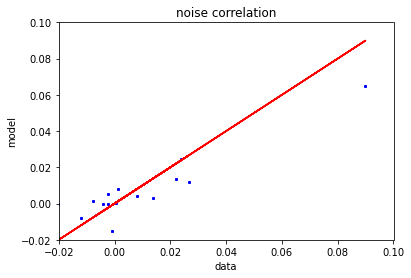

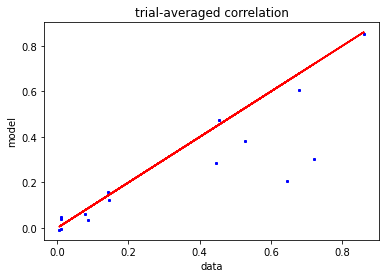

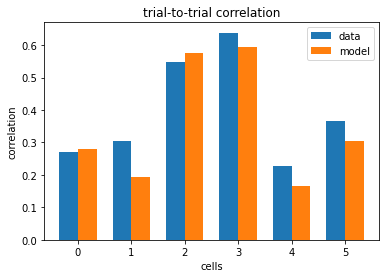

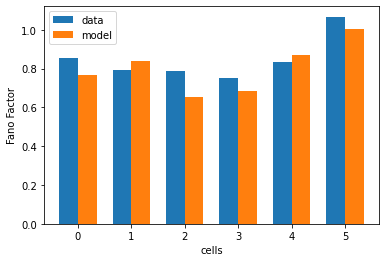

In [411]:
binomial_para =  [2.17, 2.85, 1.91, 1.69, 1., 0.47]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.55, 0], 27)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred_single_trial_pre.mean(0), n_repeats=300, seed=27, thre=15)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)

In [413]:
single_trial_bin.sum(), pred_single_trial_try.sum()

(12160.0, 6500)